# Quantum calculator
## Team #20, 2022, hackathon

We designed the addition calculator using quantum machine learning.
To generate an input data, two random floating numbers (one pair) within [0,1] were generated.
A target data was obtained from summation of the input data.

Pytorch/qiskit packages are required for running this code.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets
from torch.utils import data

from qiskit import Aer, QuantumCircuit, IBMQ
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation, PauliExpectation
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult
from qiskit.providers.ibmq import least_busy

### Check/choose the device (CPU/GPU)

In [2]:
# checking that cuda is available or not
USE_CUDA=torch.cuda.is_available()
DEVICE=torch.device("cuda" if USE_CUDA else "cpu")
#DEVICE=torch.device("cpu")
print("CUDA: {}".format(USE_CUDA))

CUDA: False


### Declare quantum simulator/quantum computer (local computer, IBM quantum computer, or IBM simulator)

In [3]:
#### IBM quantum computer ####
#IBMQ.save_account('--token--', overwrite = True)
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-education', group='ibm-3', project='korea-hackathon-')
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#qasm_sim = provider.backend.ibmq_manila
#statevec_sim = provider.backend.simulator_statevector

#qi = QuantumInstance(qasm_sim)

#### local computer using Aer package ####
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

### Data generation

In [4]:
### data generator
class Data_gen(data.Dataset):
    def __init__(self, list_IDs):
        self.list_IDs = list_IDs

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        ID = self.list_IDs[index]
        
        inputs = torch.rand(1, 2)
        target = torch.sum(inputs,dim=1)

        return inputs, target

In [5]:
## data loading setting ###
params = {'batch_size': 1, 'shuffle': True}

train_ID_set = range(1,10000) # generate 10,000 training data (it is large enough)
test_ID_set = range(1,2000) # generate 2,000 training data (it is large enough)

train_dataset = Data_gen(train_ID_set)
test_dataset = Data_gen(test_ID_set)

train_generator = data.DataLoader(train_dataset, **params)
test_generator = data.DataLoader(test_dataset, **params)
    

### Define qnn model

In [6]:
### Define QNN (reference: qiskit tutorial)
# Set seed for random generators
#algorithm_globals.random_seed = 42
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=2)

### for quantum computer
#qnn = TwoLayerQNN(
#    2, feature_map, ansatz, input_gradients=True, exp_val=PauliExpectation(), quantum_instance=qi #AerPauliExpectation()
#)

### for local simulation
qnn = TwoLayerQNN(
    2, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
)

### Define framework of quantum calculator

In [7]:
class qnn_calculator(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc2 = nn.Linear(1, 1)  
        
    def forward(self, x):
        x = self.qnn(x)  # apply QNN
        x = self.fc2(x)
        
        return x.view(-1)  
    
model = qnn_calculator().to(DEVICE)

### Set parameters for traininig/testing

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 10;
Ntrain_data = 200;
Ntest_data = 50;

### Train/Test the model (local computer/ simulator)

In [9]:
train_losses, test_losses, accuracy_list = [], [], []

for e in range(epochs):
    running_loss = 0
    j = 0
    
    for i, (inputs, targets) in enumerate(train_generator):        
        inputs=inputs.view(-1,2)
        targets=targets.view(-1)

        if  j < Ntrain_data:
            
            optimizer.zero_grad()
            output = model(inputs).float()
            loss = criterion(output, targets.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            j= j + 1

    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            j = 0
            
            for i, (inputs, targets) in enumerate(test_generator):
                inputs=inputs.view(-1,2)
                targets=targets.view(-1)
                
                if  j < Ntest_data:
                    output = model(inputs).float()
                    test_loss += criterion(output, targets.float())
                    refine_output = torch.round(output)
                    accuracy=accuracy+torch.abs(output-torch.sum(inputs)).float()
                                     
                    j = j + 1
        
        train_losses.append(running_loss/Ntrain_data)
        test_losses.append(test_loss/Ntest_data)
        accuracy_list.append(accuracy[0]/Ntest_data)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/Ntrain_data),
              "Test Loss: {:.3f}.. ".format(test_loss/Ntest_data),
              "L1 error: {:.3f} ".format(accuracy[0]/Ntest_data))

Epoch: 1/10..  Training Loss: 0.631..  Test Loss: 0.175..  L1 error: 0.346 
Epoch: 2/10..  Training Loss: 0.085..  Test Loss: 0.077..  L1 error: 0.209 
Epoch: 3/10..  Training Loss: 0.059..  Test Loss: 0.078..  L1 error: 0.220 
Epoch: 4/10..  Training Loss: 0.057..  Test Loss: 0.049..  L1 error: 0.172 
Epoch: 5/10..  Training Loss: 0.058..  Test Loss: 0.040..  L1 error: 0.164 
Epoch: 6/10..  Training Loss: 0.061..  Test Loss: 0.069..  L1 error: 0.215 
Epoch: 7/10..  Training Loss: 0.056..  Test Loss: 0.074..  L1 error: 0.210 
Epoch: 8/10..  Training Loss: 0.067..  Test Loss: 0.059..  L1 error: 0.189 
Epoch: 9/10..  Training Loss: 0.051..  Test Loss: 0.043..  L1 error: 0.163 
Epoch: 10/10..  Training Loss: 0.052..  Test Loss: 0.049..  L1 error: 0.160 


### train using qiskit runtime package (only for IBM quantum computer)

In [ ]:
torch_runtime_client = TorchRuntimeClient(
    provider=provider,
    model=model,
    optimizer=optimizer,
    loss_func=criterion,
    epochs=epochs,
    backend=qasm_sim,
)

fit_result = torch_runtime_client.fit(train_loader=train_generator, val_loader=test_generator)

### Test the trained model

In [19]:
input_test = torch.rand(1,2)[0] # generate input data randomly
output = model(input_test).to(DEVICE) # run the trained model

print('input: {}'.format(input_test))
print('ground_truth: {}'.format(torch.sum(input_test)))
print('prediction: {}'.format(output[0]))
print('L1 error: {}'.format(torch.abs(output-torch.sum(input_test))[0]))

input: tensor([0.7413, 0.3332])
ground_truth: 1.0745712518692017
prediction: 1.139599084854126
L1 error: 0.06502783298492432


### Plot the loss

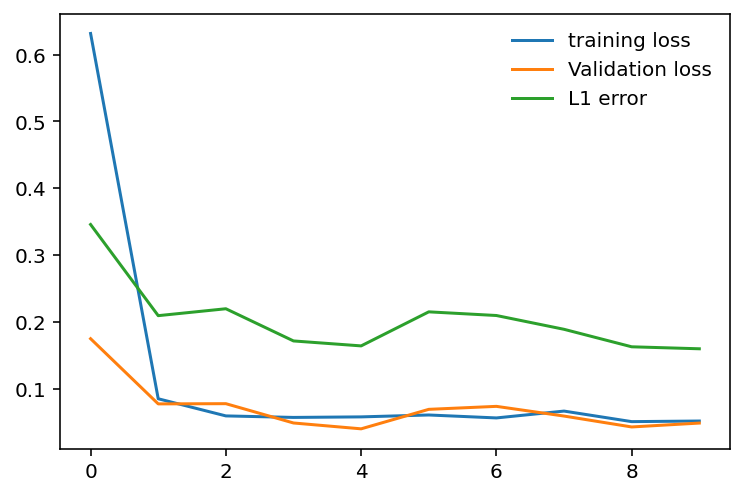

In [14]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.plot(accuracy_list, label='L1 error')
plt.legend(frameon=False)